![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

# Edge Detection

# Images

In [ ]:
!wget https://www.dropbox.com/s/ux8t0p2zwupj0qe/C0031_0019.png
!wget https://www.dropbox.com/s/f73bis9jnz3a9ic/estuche.png

--2023-11-08 18:19:28--  https://www.dropbox.com/s/ux8t0p2zwupj0qe/C0031_0019.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ux8t0p2zwupj0qe/C0031_0019.png [following]
--2023-11-08 18:19:29--  https://www.dropbox.com/s/raw/ux8t0p2zwupj0qe/C0031_0019.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95074e940b5d2b040f3f9c07bb.dl.dropboxusercontent.com/cd/0/inline/CHL_ddF20puXxmKkdGa9KqapvbP8qdckYJ9HZ-k-lY_kx5tOoDD_aX1s5uvw1XXjo2UYsg7tUE6RcgdSK7mz4kEuHA0KmHIuSThh2n_tVL_hwWqmqfQcr0Nb0hqdNAdjpS4/file# [following]
--2023-11-08 18:19:30--  https://uc95074e940b5d2b040f3f9c07bb.dl.dropboxusercontent.com/cd/0/inline/CHL_ddF20puXxmKkdGa9KqapvbP8qdckYJ9HZ-k-lY_kx5tOoDD_aX1s5uvw1XXjo2UYsg7tUE6RcgdSK7mz4kEuHA0KmHIuSThh2n_tVL_hwWqmqfQ

# Libraries

In [ ]:
import matplotlib.pylab as plt
import cv2
import numpy as np
from skimage.morphology import binary_dilation
from skimage.segmentation import clear_border,find_boundaries
from skimage.morphology import disk
from skimage.feature import canny


In [ ]:
from skimage.color import label2rgb
from skimage.measure import label

# (c) Christian Pieringer and Domingo Mery

def binview(img, mask, color='r', dilate_pixels=1):
    """
    Displays a gray or color image 'img' overlaid by color pixels determined a by binary image 'mask'. It is useful to
    display the edges of an image.

    Args:
        img: gray scale image (X-ray)
        mask: binary image that works as mask
        color: string to define pixel color.
                'r': red (default)
                'g': green
                'b': blue
                'y': yellow
                'c': cyan
                'm': magenta
                'k': black
                'w': white

        dilate_pixels (int): Number of pixels used for dilate the mask.

    Returns:
        img_color (ndarray): output image with a mask overlaid.
    """

    # Defines colors
    # colors = {
    #     'r': np.array([255, 0, 0]),
    #     'g': np.array([0, 255, 0]),
    #     'b': np.array([0, 0, 255]),
    #     'y': np.array([255, 255, 0]),
    #     'c': np.array([0, 255, 255]),
    #     'm': np.array([255, 0, 255]),
    #     'k': np.array([0, 0, 0]),
    #     'w': np.array([255, 255, 255])
    # }
    #
    colors = {
        'r': np.array([1, 0, 0]),
        'g': np.array([0, 1, 0]),
        'b': np.array([0, 0, 1]),
        'y': np.array([1, 1, 0]),
        'c': np.array([0, 1, 1]),
        'm': np.array([1, 0, 1]),
        'k': np.array([0, 0, 0]),
        'w': np.array([1, 1, 1])
    }
    # Create a RGB image from grayscale image.
    img_color = np.dstack((img, img, img))

    # Ensure do not modify the original color image and the mask
    img_color = img_color.copy()

    mask_ = mask.copy()
    # mask_ = dilate(mask_, np.ones((g, g), np.uint8))
    mask_ = binary_dilation(mask_, np.ones((dilate_pixels, dilate_pixels)))

    # Now black-out the area of the mask
    # img_fg = bitwise_and(img, img, mask=mask_)

    # Defines the pixel color used for the mask in the figure.
    cc = colors[color]
    #
    # for i in range(3):
    #     img_color[:, :, i] = cc[i] * img_fg

    # remove artifacts connected to image border
    cleared = clear_border(mask_)
    if np.all(cleared):
        mask_ = cleared

    # label image regions
    label_image = label(mask_)
    img_color = label2rgb(label_image, image=img_color, colors=[cc], bg_label=0)

    return img_color  # add(img_color, img_color)


In [ ]:
class Edge:
    """
    This class implements methods for edge detection required for examples used
    in the book.
    """

    def __init__(self, _method, _thres=None, _sigma=1.0):
        """
        Args:
            method (str): It defines the detector method:
                'log': Laplacian of Gaussian
                'canny': Canny edge detection
            thres (float): It defines the threshold to noise supression
            sigma (float): It specifies the scale of the kernel
        """

        _valid_methods = ['log', 'canny', 'sobel']

        super().__init__()

        # Check input parameters
        if _method not in _valid_methods:
            raise ValueError('{} is not a valid method for edge detection.'.format(_method))

        self.method = _method
        self.thres = _thres
        self.sigma = _sigma
        self._returns = None  # Keep track outputs

    def detect_zero_crossing(self, edges):
        """
        Performs zero crossing detection.

        Args:
            edges (float ndarray): input image in edges

        Return:
            out_img (ndarray): image of edges.
        """

        # def any_neighbor_zero(img, i, j):
        #     """
        #     This function verifies neighborhood around boundary pixels.
        #
        #     """
        #     for k in range(-1, 2):
        #         for l in range(-1, 2):
        #             if img[i + k, j + k] == 0:
        #                 return True
        #     return False
        #
        # # Makes a copy of the original image and
        # # marks as 1 pixels greater that 0.
        # _edges = edges.copy()
        # _edges[_edges > self.thres] = 1
        # _edges[_edges <= self.thres] = 0
        #
        # # _edges = np.abs(_edges)
        # # _edges = _edges > self.thres
        #
        # # print(np.max(_edges), np.min(_edges))
        #
        # out_img = np.zeros(_edges.shape)
        #
        # for i in range(1, _edges.shape[0] - 1):
        #     for j in range(1, _edges.shape[1] - 1):
        #         if _edges[i, j] > 0 and any_neighbor_zero(_edges, i, j):
        #             out_img[i, j] = 1

        # Check zero crossing four directions and aggregate the output.
        out = np.diff(np.sign(edges), prepend=np.ones((edges.shape[0], 1)), axis=1) != 0
        out = np.bitwise_or(out, np.diff(np.sign(edges), prepend=np.ones((1, edges.shape[1])), axis=0) != 0)
        out = np.bitwise_or(out, (np.diff(np.sign(edges)[:, ::-1], prepend=np.ones((1, edges.shape[1])), axis=0) != 0)[:, ::-1])
        out = np.bitwise_or(out, (np.diff(np.sign(edges)[::-1, :], prepend=np.ones((1, edges.shape[1])), axis=0) != 0)[::-1, :])
        # Check gradients is on the threshold.

        grads_diff = np.abs(np.diff(edges, prepend=np.ones((edges.shape[0], 1)), axis=1)) > self.thres
        grads_diff = np.bitwise_or(grads_diff, np.abs(np.diff(edges, prepend=np.ones((1, edges.shape[0])), axis=0)) > self.thres)
        # grads_diff = np.bitwise_or(grads_diff, (np.abs(
        #     np.diff(edges[:, ::-1], prepend=np.ones((edges.shape[0], 1)),
        #             axis=1)) > self.thres)[:, ::-1])
        # grads_diff = np.bitwise_or(grads_diff, (np.abs(
        #     np.diff(edges[::-1, :], prepend=np.ones((1, edges.shape[0])),
        #             axis=0)) > self.thres)[::-1, :])

        out_img = np.bitwise_and(out, grads_diff)

        return out_img

    def fit(self, img):
        """
        This method detect edges in an image. Method must be choose during class
        instantiation.

        Args:
            img: input image in numpy array format.

        Returns:
            None
        """

        self._returns = dict()
        self._returns.update({'edges': None})

        if self.method == 'log':
            _ksize = int(2 * np.ceil(3 * self.sigma) + 1)
            _log_kernel = fspecial(self.method, _ksize, self.sigma)
            _log = cv2.filter2D(img.astype('double'), cv2.CV_64F, _log_kernel)
            _log = _log / np.sum(_log.flatten())  # Normalize gradients to sum 0
            _edges = self.detect_zero_crossing(_log)

            self._returns.update({'kernel': _log_kernel})  # Keep used kernel

        elif self.method == 'canny':
            """
            Canny edge detector. This option implement a wrapper to apply the
            scikit image implementation for this edge detector. It present an
            interface with similar parameters to the MATLAB version.
            """
            _edges = canny(
                img.astype('double'),
                sigma=self.sigma,
                low_threshold=self.thres,
                high_threshold=self.thres / 0.4
            )

        # Keep the output if does exists
        self._returns.update({'edges': _edges})

    @property
    def edges(self):
        return self._returns['edges']

    @property
    def kernel(self):
        return self._returns['kernel'] if self.method != 'canny' else None


In [ ]:
def prewitt_kernel(size=3, *args):
    """
    This function create a Prewitt Kernel. The default size is 3 x 3 kernel.
    :param size:
    :param args:
    :return:
    """

    prewitt = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype='double')
    return prewitt


def sobel_kernel(size=3, *args):
    """
    This method create a Sobel Kernel. The standar size is a 3 x 3 kernel.

    :param size: int value to define the kernel size.

    :return:
    """

    sobel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype='double')
    return np.transpose(sobel)


def gaussian_kernel(size, sigma, *args):
    """
    This method creates a symmetric Gaussian kernel.

    :param sigma: float number that defines the width of the Gaussian
            distribution
    :param size: inf number to specify the size of the kernel.
            Typical numbers 3, 5, 9, 11.
    """
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1,
           -size // 2 + 1:size // 2 + 1]

    kernel = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    kernel = kernel / kernel.sum()

    return kernel.astype('double')


def log_kernel(size, sigma, *args):
    """
    This option creates a Laplacian of Gaussian Kernel centered at
    the middle of the kernel

    :param size: integer value to define the size of the kernel.
    :param sigma: float value for the scale factor.
    :returns: a numpy array with the LoG kernel.

    """

    x, y = np.meshgrid(np.arange(-size - 1 / 2 + 1, size - 1 / 2 + 1),
                       np.arange(-size - 1 / 2 + 1, size - 1 / 2 + 1))

    # LoG filter
    # normal = -1.0 / (2.0 * np.pi * sigma ** 2)

    # kernel = ((x ** 2 + y ** 2 - (2.0 * sigma ** 2)) / sigma ** 4)
    # kernel = kernel * np.exp(-(x ** 2 + y ** 2) / (2.0 * sigma ** 2))
    # kernel = kernel / normal

    kernel = x ** 2 + y ** 2
    kernel = (-1 / (np.pi * sigma ** 4)) * (
                1 - kernel / (2 * sigma ** 2)) * np.exp(
        -kernel / (2 * sigma ** 2))

    # Normalize ensuring 0 DC. See Peter Kovesi's Toolbox
    kernel = kernel - np.mean(kernel.flatten())

    return kernel


In [ ]:
def fspecial(kernel_name, size=3, sigma=1.0):
    """
    This method mimic the 'fspecial' gaussian MATLAB function to create
    special kernel functions used in computer vision.

    Reference: https://src-bin.com/en/q/1064ef9

    :param kernel_name: a string to define the type of window:
                'sobel': Sobel kernel
                'prewitt': Prewitt kernel
                'gaussian': standard Gaussian window
                'log': Laplacian of Gaussian Kernel

    :param size: integer to define the length of the window
    :param sigma: a float number to define the sigma of the kernel
    """

    _kernel_kwarg = {
        'sobel': sobel_kernel,
        'prewitt': prewitt_kernel,
        'gaussian': gaussian_kernel,
        'log': log_kernel
    }

    # _img_generate kernel function
    kernel = _kernel_kwarg[kernel_name](size, sigma)

    return kernel


In [ ]:
def im_grad(img, kernel):
    """
    This method compute the gradient of a image 'img'. It uses the OpenCV
    function "filter2D". In the filter function 'same' is the default and the
    only one option.

    :param img: a uint8 input image.
    :param kernel: a kernel as nd-array. Commonly used kernels are Prewitt,
                    _img_gaussians, or Sobel.

    :returns: The images of magnitude (mag) and angle (angle).

    """

    # TODO: check arguments

    gradi = cv2.filter2D(img.astype('double'), cv2.CV_64F, kernel)
    gradj = cv2.filter2D(img.astype('double'), cv2.CV_64F, kernel.T)

    mag = np.sqrt(gradi ** 2 + gradj ** 2)
    angle = np.arctan2(gradj, gradi)

    return mag, angle

def linimg(img, t=255):
    """
    This method computes the Linear enhancement of image I from 0 to 255,
    or 0 to 1.

    :param img: a grayvalue image I.
    :param t: if t==255 output will be a unit8 image with gray values going from
              0 to 255. Else, output will a double image with gray values from
              0 to t.

    :returns: enhanced image J (uint8 or double) so that:
                J = m*I + b; where min(J) = 0, max(J) = 255 or 1.

    """

    img = np.double(img.copy())
    mi = np.min(img.flatten())
    mx = np.max(img.flatten())
    d = mx - mi

    if d == 0:
        out = (img / mx) * (t / 2)
    else:
        out = ((img - mi) / d) * t

    if t == 255:
        out = np.round(out)

    return out.astype('uint8')



In [ ]:
def show_image_as_surface(img, cmap='viridis', elev=-120, azim=40, fsize=None, colorbar=False):
    """
    This function display a mesh plot of an image. This is not a 3D visualization.

    Args:
        img:
        cmap:
        elev:
        azim:

    Returns:
        None
    """
    # Create the x and y coordinate arrays
    xx, yy = np.mgrid[0:img.shape[0], 0:img.shape[1]]

    if not fsize:
        fsize = (8, 8)

    # create the figure
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(xx, yy, img,
                           rstride=1,
                           cstride=1,
                           cmap=cmap,
                           linewidth=0)
    ax.view_init(elev, azim)

    if colorbar:
        fig.colorbar(surf, shrink=0.5, aspect=5, pad=0.01)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# Prewitt + Sobel + Gaussian

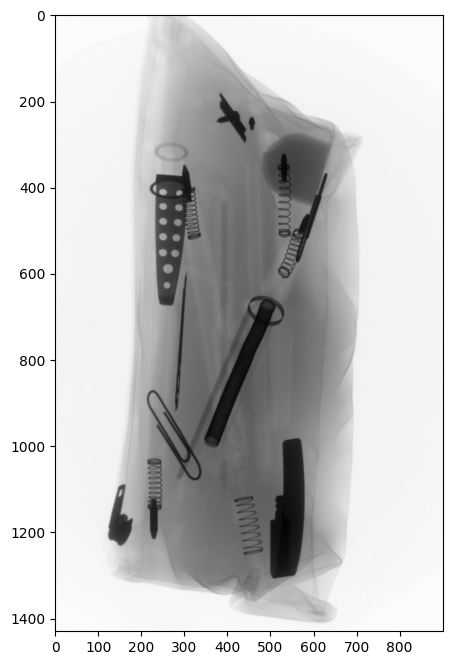

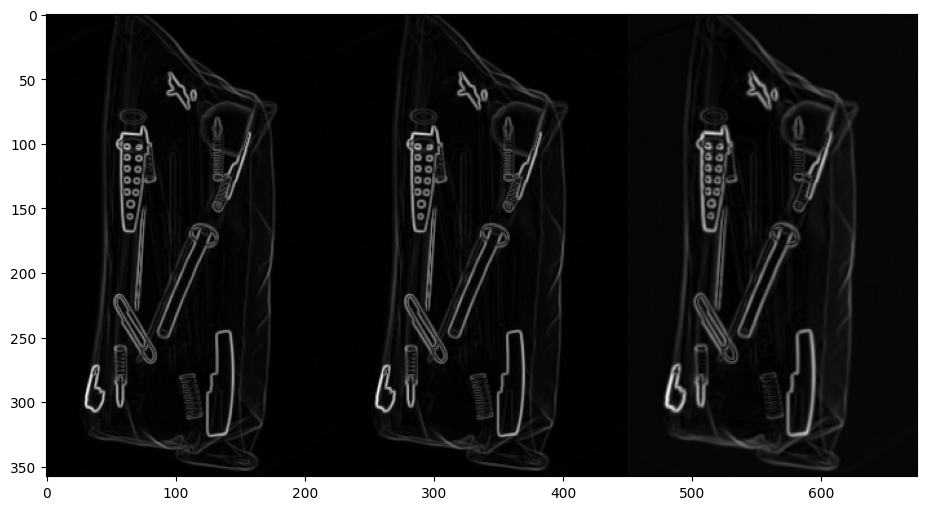

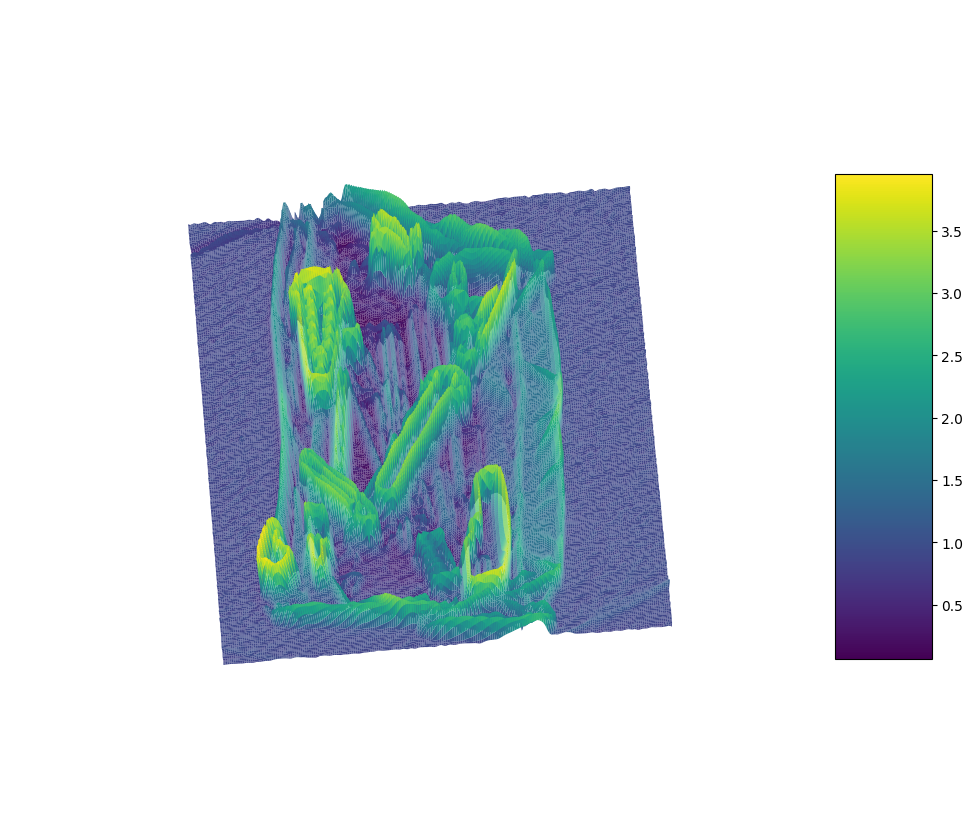

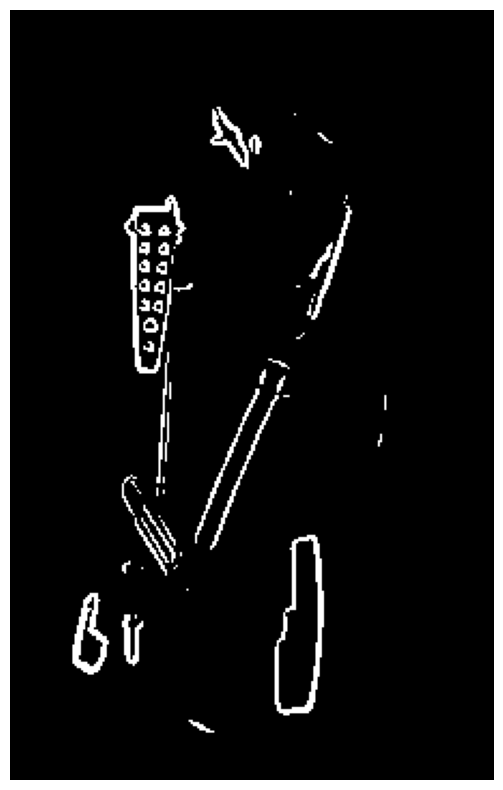

In [ ]:
X = cv2.imread('estuche.png',0)
plt.figure(figsize=(14, 8))
plt.imshow(X,cmap = 'gray')
plt.show()

img = cv2.resize(X, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_AREA)

hs = fspecial('sobel')    # Sobel kernel
hp = fspecial('prewitt')  # Prewitt kernel

hg = fspecial('gaussian', 9, 1.0)
hg = cv2.filter2D(hg, cv2.CV_64F, np.array([-1, 1]))

gs, __ = im_grad(img, hs)
gp, __ = im_grad(img, hp)
gg, __ = im_grad(img, hg)

gradients = np.hstack([linimg(gs), linimg(gp), linimg(gg)])  # Stack the results as a same image.

plt.figure(figsize=(12, 6))
plt.imshow(gradients, cmap='gray')
plt.show()

img_y = np.log(gg + 1)

show_image_as_surface(img_y[-5:5:-1, -5:5:-1], elev=80, azim=-185, fsize=(10, 10), colorbar=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_y > 3, cmap='gray')
ax.axis('off')
plt.show()


# LoG

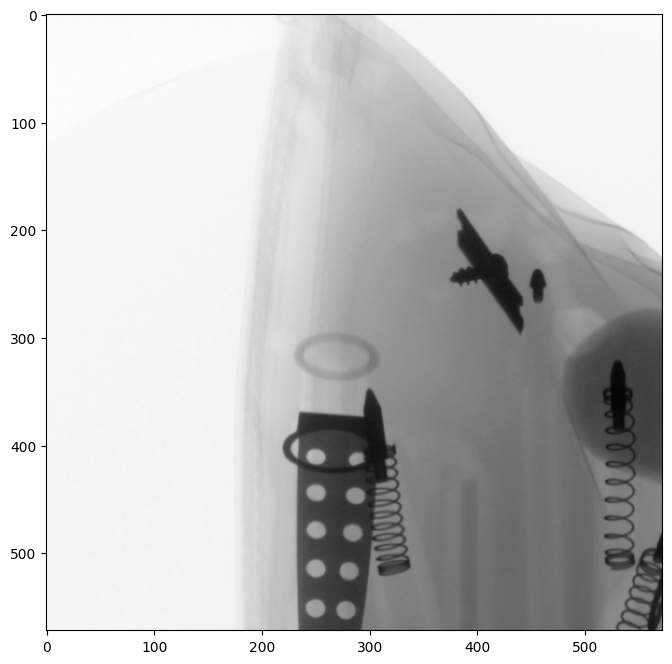

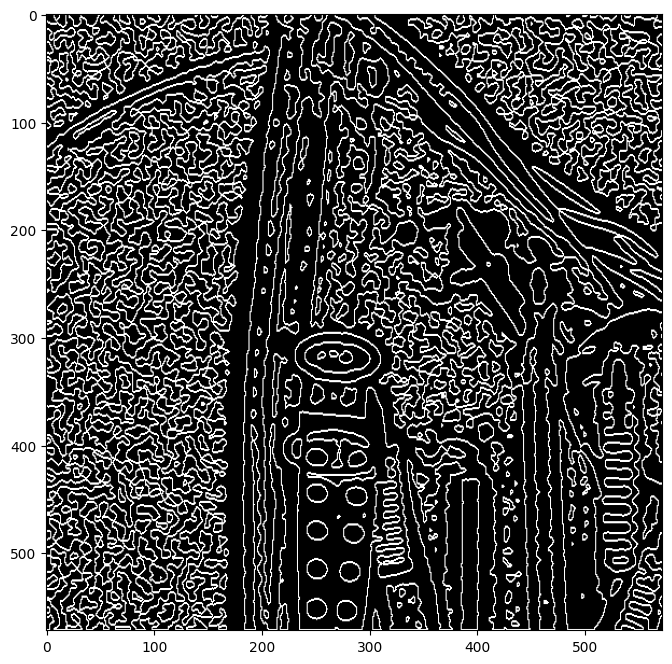

In [ ]:
X = cv2.imread('estuche.png',0)
X = X[0:572, 0:572]  # Cropping the image
plt.figure(figsize=(14, 8))
plt.imshow(X,cmap = 'gray')
plt.show()
sigma = 3
edge = Edge('log', 1e-8, sigma)  # Edge detection using log
edge.fit(X)

b = edge.edges.astype(np.uint8)
plt.figure(figsize=(14, 8))
plt.imshow(b,cmap='gray')
plt.show()

# Canny

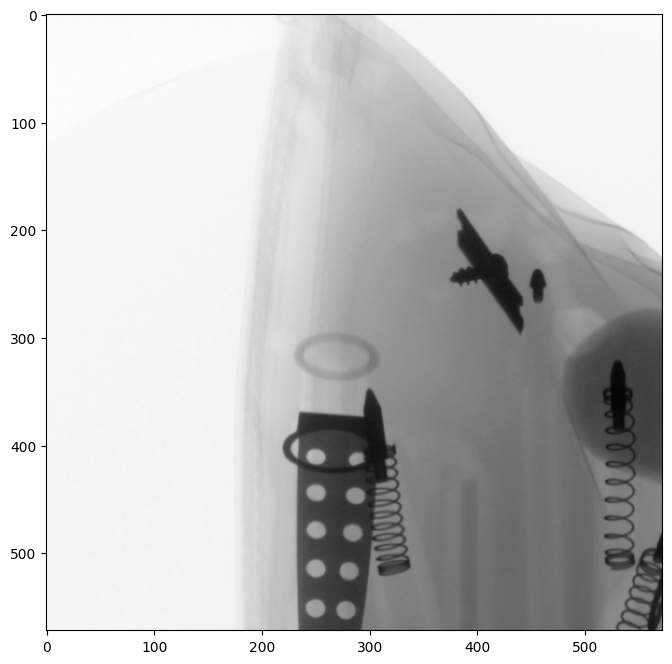

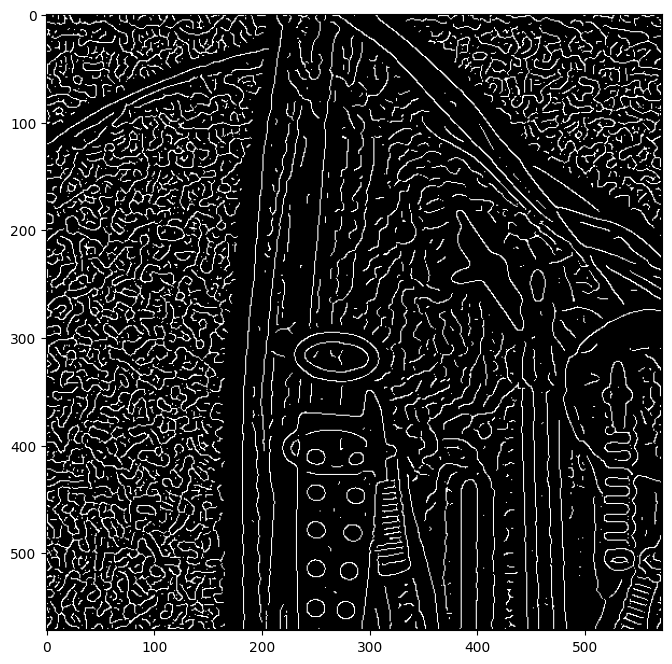

In [ ]:
X = cv2.imread('estuche.png',0)
X = X[0:572, 0:572]  # Cropping the image
plt.figure(figsize=(14, 8))
plt.imshow(X,cmap = 'gray')
plt.show()
sigma = 3
edge = Edge('canny', 1e-8, sigma)  # Edge detection using log
edge.fit(X)

b = edge.edges.astype(np.uint8)
plt.figure(figsize=(14, 8))
plt.imshow(b,cmap='gray')
plt.show()

# Segmentation Approach using LoG

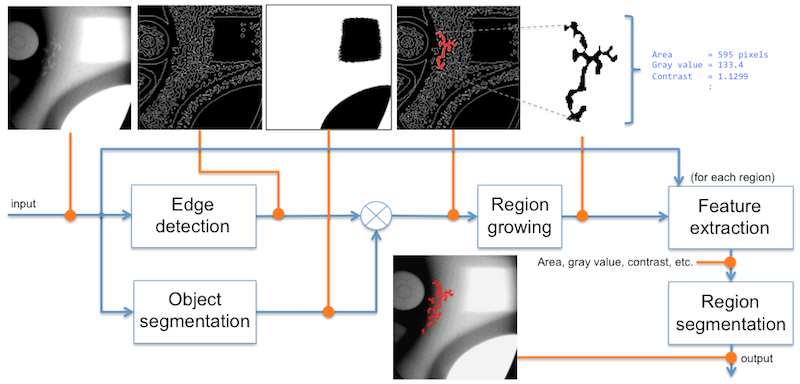

In [ ]:
def seg_log_feature(_img, _mask=None, area=None, gray=None, contrast=None, sigma=None):
    """

    """
    if _mask.all():
        _mask = np.ones(_img.shape)

    # Unpackage parameters
    amin = area[0]
    amax = area[1]
    gmin = gray[0]
    gmax = gray[1]
    cmin = contrast[0]
    cmax = contrast[1]

    se = disk(3)  # Structural element
    re = binary_dilation(_mask, se)

    e = clear_border(find_boundaries(_mask, connectivity=1, mode='inner')).astype(np.uint8)
    edge = Edge('log', 1e-8, sigma)  # Edge detection using log
    edge.fit(_img)

    b = edge.edges.astype(np.uint8)
    b = np.bitwise_and(b, re)
    b = np.bitwise_or(b, e)
    b = clear_border(np.bitwise_not(b))

    f, m = label(b, connectivity=1, return_num=True)  # Connectivity=1 == 4 Neighboors

    d = np.zeros(_img.shape).astype(np.uint8)

    for i in range(m):
        r = f == i
        b = np.bitwise_xor(r, binary_dilation(r, np.ones((17, 17)))).astype(np.uint8)
        ir = r == 1
        ib = b == 1
        area = np.sum(ir.flatten())
        gray_r = np.mean(_img[ir].flatten())
        gray_b = np.mean(_img[ib].flatten())
        contrast = gray_r / gray_b

        if (area >= amin) and (area <= amax) and (gray_r >= gmin) and (gray_r <= gmax) and (contrast >= cmin) and (contrast <= cmax):
            d = np.bitwise_or(d, r)

    f, m = label(d, connectivity=1, return_num=True)  # Connectivity=1 == 4 Neighboors

    return f, m


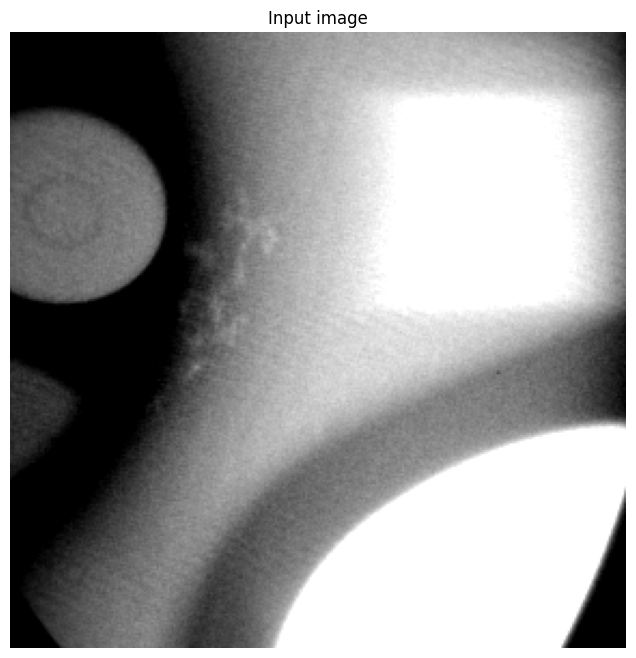

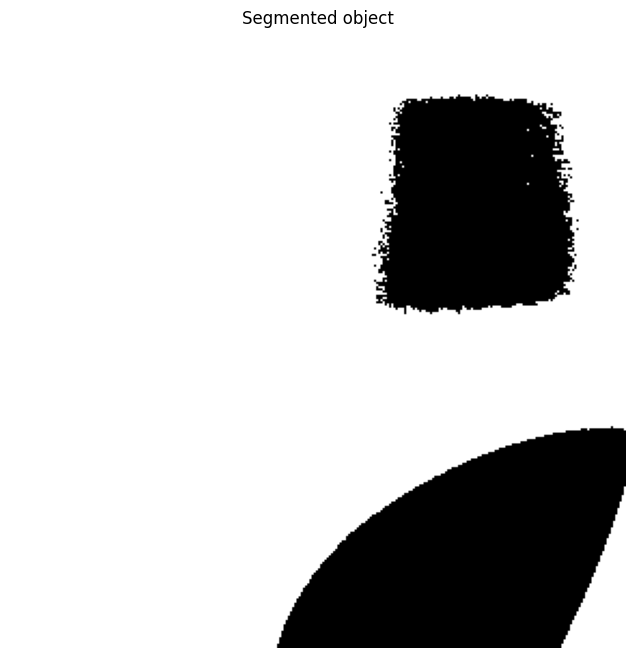

Found 6 regions.


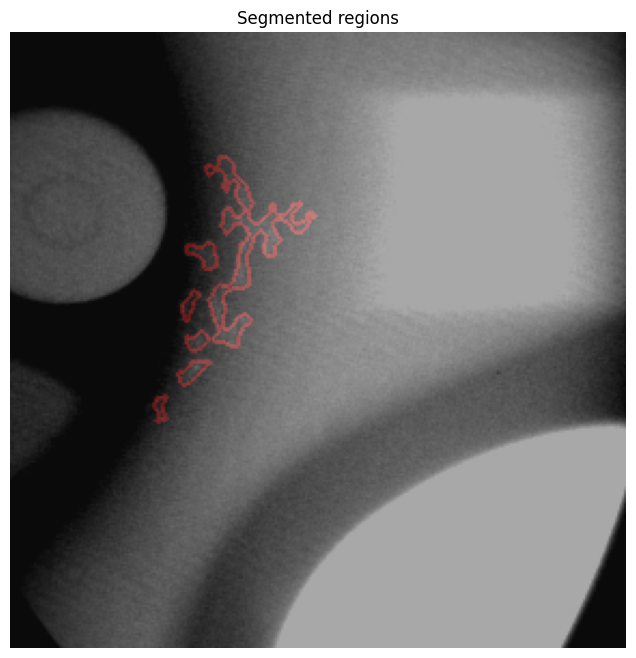

In [ ]:
X = cv2.imread('C0031_0019.png',0)
X = X[0:572:2, 0:572:2]  # Donwsampling the image

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.imshow(X, cmap='gray')
ax1.set_title('Input image')
ax1.axis('off')
plt.show()

R = X < 240

fig2, ax2 = plt.subplots(1, 1, figsize=(8,8))
ax2.imshow(R, cmap='gray')
ax2.set_title('Segmented object')
ax2.axis('off')
plt.show()

options = {
    'area': (30, 1500),  # Area range (area_min, area_max)
    'gray': (0, 150),  # Gray value range (gray_min, gray_max)
    'contrast': (1.08, 1.8),  # Contras range (cont_min, cont_max)
    'sigma': 2.5
}

Y, m = seg_log_feature(X, R, **options)

print(f'Found {m} regions.')

fig3, ax3 = plt.subplots(1, 1, figsize=(8, 8))
ax3.imshow(binview(X, find_boundaries(Y)), cmap='gray')
ax3.set_title('Segmented regions')
ax3.axis('off')
plt.show()